# Project Overview

__Business Problem__

This project uses regression analysis to solve the problem of disposable buildings, or usage of buildings for a short life cycle. Building longevity, defined as the years of service of a building, has gone down over history resulting in the shortest building lifespans ever before in history. This creates an excess of physical waste being sent to landfills, and also reduces the potential return on investment for building owners. Most buildings generate revenue, so the longer they are in service, the greater return for the owner.

__Customers__

The potential users who would benefit from this analysis include long-term building owners such as real estate corporations and government agencies. Companies such as JLL, CBRE, and the Related Company own portfolios of hundreds or thousands of buildings. Government agencies such as HUD, the US Army Corps of Engineers, and Navy Facilities Command also own and maintain large portfolios. These customers are constantly evaluating whether to build new, renovate existing properties, or some combination of the th two.  Predicting building life span would benefit these customers by giving them a baseline understanding of what is the typical lifespan of a building within the set of buildings that are demolished.


__Analysis__

This analysis studies only demolished buildings. Future study could include study of existing buildings as well. Since some buildings are never demolished, or last far longer than typical buildings, these have different properties that can't be understood from studying only demolished buildings. However, a study of demolished buildings can reveal what factors may have influenced demolition and how this may be avoided for owners wishing to use their buildings for a longer lifespan.



__Data__

Data was obtained from two sources: PLUTO, or Primary Land Use Tax Output, and NYC Open Data  Department of Buildings (DOB) Permit Issuance.

Pluto is a a system for keeping track of New York City land use data by lot. PLUTO compiles data from multiple sources including the NYC Department of City Planning, Department of Finance, Landmarks Preservation Commission, and the Department of Information, Telecommunications and Technology.

The permits data is being used to filter out the PLUTO data. The only columns from the permits data that are needed for this purpose are the columns used to merge (borough, block, and lot) as well as 'Bldg Type' (used to filter to commercial buildings), 'Residential' to check filtering, 'Permit Type' and 'Issuance Date' which describes when the demolition began. All other columns from this dataset are dropped.

__Data Cleaning__

The following columns will be dropped for too many missing values:
- masdate
- polidate

The following columns will be dropped beause they are not relevant:
- zmcode, a code which identifies a tax lot on the border of two zoning maps.  
- condono, the condominium number.
- owner name
- ct2010, the 2010 census tract in which the tax lot is located.
- tract2010, The 2010 census tract in which the tax lot is located. 
- cb2010, the 2010 census block in which the tax lot is located.
- firecomp, the fire company that services the tax lot.
- sanborn, the Sanborn Map Company map number associated with the tax block and lot.
- sanitsub, the subsection of the sanitation district that services the tax lot.
- address
- areasource, a code indicating the methodology used to determine the tax lot's TOTAL BUILDING FLOOR AREA (BldgArea) 
- zonemap, Department of City Planning Georeferenced NYC Zoning Maps 
- taxmap, the Department of Finance paper tax map volume number associated with the tax block and lot.
- appbbl, the originating BBL (borough, block and lot) from the apportionment prior to the merge, split or property’s conversion to a condominium.   
- appdate, the date of the apportionment to merge or split the property or convert to a condominium. 
- plutomapid, a code indicating whether the tax lot is in the PLUTO file, the MapPLUTO file with water areas included, and/or the MapPLUTO file that is clipped to the shoreline.
- rpaddate, not sure what this date represents, all values have the same date (not listed in the data dictionary.)
- dcasdate, not sure what this date represents, all values have the same date (not listed in the data dictionary.)
- edesigdate, not sure what this date represents, all values have the same date (not listed in the data dictionary.)
- geom, a code of numbers and letters that is illegible.
- zipcode, no need to sort by zip for the goal of the project.

The following columns will be dropped because they are redundant with another column:
- sanitboro, redundant with borough
- Borough, redundant with borocode
- version, the version number for this release of PLUTO.

The following rows with missing values will be dropped:
- yearbuilt
- Some tax lots have more than one building. Rows for lots with more than one building will be dropped.


The PLUTO data will be filtered using BBL number. \
BBL stands for borough, block and lot. \
example bbl number 1011270029:\
borough 1 for Manhattan\
block 01127\
lot 0029

## Imports

In [42]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from statsmodels.tools.eval_measures import rmse

## Data Cleaning - PLUTO

__Columns Used for Model__

block  - location identifier which may be used if concatenating with other data 

lot - location identifier which may be used if concatenating with other data 

bbl, a concatenation of the borough code, tax block and tax lot - keep in order to merge with demo permit data. 

cd - Community District, of the 59 community districts in NYC. Different districts may tend to maintain buildings better or worse, or have different development patterns.                
schooldist - school district, affects population movement patterns which drive density and development.

council - city council district. Different districts may tend to maintain buildings better or worse, or have different development patterns.               

policeprct - police precinct, relevant because crime affects property values and development patterns.

healtharea - Health areas were originally created in the 1920s for the purpose of reporting and  statistical analysis of public health data. They were based on census tracts and created to be areas of equal population. Health areas are contained within health center districts. Buildings affect public health and a


For the remaining columns after other cleaning procedures, refer to the 01-Cleaning-Permits file.

In [27]:
df = pd.read_csv('data/pluto_19v1.csv')

# for land use category, filter out 01 one and two family dwellings, 09 Open Space & Outdoor Recreation, 
# 11 Vacant Land, the remainder is lots with buildings
df = df[df['landuse'] != (1.0 or 9.0 or 11.0)]

# filter to show only the lots with one building
df = df[df['numbldgs'] == 1.0]

df.drop(axis=1, columns=['masdate', 'polidate', 'zmcode', 'condono', 'ownername', 'ct2010', 'tract2010', 'cb2010', 'firecomp',
                 'sanborn', 'sanitsub', 'address', 'areasource', 'zonemap', 'taxmap', 'appbbl', 'appdate', 'plutomapid',
                 'rpaddate', 'dcasdate', 'edesigdate', 'geom', 'sanitboro', 'borough', 'version', 'zmcode', 'zipcode'], 
        inplace=True)

# drop rows with nan in yearbuilt column
df.dropna(axis=0, how='any', inplace=True, subset=['yearbuilt'])

#send cleaned file to csv
df.to_csv('data/nyc_lots.csv')

/opt/anaconda3/envs/capstone_env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (16,17,18,20,22) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


# Data Cleaning - NYC Permits

__Comments__\
The column 'Issuance Date' is needed because if a new building was built after the building was demolished, 
(after the demolition permit issuance date), then the lot data would reflect the new building, not the demolished building. 

__Comments__
- Bldg Types:\
    1.0 single family\
    2.0 two family\
    NAN anything other than one or two family

In [28]:
permits = pd.read_csv('data/DOB_Permit_Issuance.csv', low_memory=False)

# filter for DM which is demolition permits
permits = permits[permits['Permit Type'] == 'DM']

permits_condensed = permits[['BOROUGH', 'Block', 'Lot', 'Bldg Type', 'Residential', 'Permit Type', 'Issuance Date']]

# Removing rows with missing values in 'Issuance Date' column
permits_condensed.dropna(axis=0, subset=['Issuance Date'], inplace=True)

# filtering out Bldg Types 1.0 and 2.0 to remove single family and duplex residential. 
# Multifamily apartments and condos are considered commercial for this analysis.
demo_permits = permits_condensed[permits_condensed['Bldg Type'] != (1.0 or 2.0)]

# drop bldg type, residential, Permit Type columns
demo_permits.drop(columns=['Bldg Type', 'Residential', 'Permit Type'], inplace=True)

# add column for borough code, for the purpose of making a bbl column (borough, block and lot) so that the dataframe can be merged with lot data.
# 1 = Manhattan
# 2 = Bronx
# 3 = Brooklyn
# 4 = Queens
# 5 = Staten Island

demo_permits['Borough Code'] = demo_permits['BOROUGH']
demo_permits['Borough Code'].replace('MANHATTAN','1', inplace=True)
demo_permits['Borough Code'].replace('BRONX', '2', inplace=True)
demo_permits['Borough Code'].replace('BROOKLYN', '3', inplace=True)
demo_permits['Borough Code'].replace('QUEENS', '4', inplace=True)
demo_permits['Borough Code'].replace('STATEN ISLAND', '5', inplace=True)

demo_permits.drop(columns=['BOROUGH'], inplace=True)

for index in demo_permits.index:
    length_existing = len(str(demo_permits['Lot'][index]))    
    length_existing
    if length_existing > 4:        
        new_lot_number = demo_permits['Lot'][index][1:5]
        demo_permits['Lot'][index] = new_lot_number 

# changing block column to 5 digits 

for index in demo_permits.index:  
    existing_number = str(demo_permits['Block'][index]).split('.') 
    length_existing = len(existing_number[0])        
    if length_existing < 5:
        number_of_new_zeros = 5 - length_existing
        new_block_value = number_of_new_zeros * '0' + existing_number[0]  
        demo_permits['Block'][index] = new_block_value   

# changing Lot column to 4 digits 
for index in demo_permits.index:  
    existing_number = str(demo_permits['Lot'][index]).split('.')
    length_existing = len(existing_number[0])        
    if length_existing < 4:
        number_of_new_zeros = 4 - length_existing
        new_block_value = number_of_new_zeros * '0' + existing_number[0]  
        demo_permits['Lot'][index] = new_block_value  
        
#add column for bbl
demo_permits['bbl'] = demo_permits['Borough Code'] + demo_permits['Block'] + demo_permits['Lot']        

<ipython-input-28-8513757a9ee3>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  permits_condensed.dropna(axis=0, subset=['Issuance Date'], inplace=True)
/opt/anaconda3/envs/capstone_env/lib/python3.8/site-packages/pandas/core/frame.py:4157: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
<ipython-input-28-8513757a9ee3>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

## Import Lots Dataframe (PLUTO) & Merge

In [29]:
# importing nyc lots dataframe
nyc_lots = pd.read_csv('data/nyc_lots.csv')

#changing datatype of bbl column
nyc_lots['bbl'] = nyc_lots['bbl'].astype(str)

# Merge Demolition Dataset and NYC Lots Dataset (Outer)
merged_df_outer = pd.merge(demo_permits, nyc_lots, on='bbl', how='outer')

/opt/anaconda3/envs/capstone_env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (10,11,13,15) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## Clean Merged Data

__Comments__\
The Issuance Year column is useful. There is a wide range of years that demo permits were issued, from 1989-2020.

In [30]:
# drop rows that have nan in yearbuilt
merged_df_outer.dropna(axis=0, subset=['yearbuilt'], inplace=True)

# Create Issuance Year Column
extracted_years = []
for val in merged_df_outer['Issuance Date']:    
    if type(val) != str: 
        val = str(val)
    if val[2] == '/':
        extracted_year = val[-4:]
    else:
        extracted_year = val[0:4]
    extracted_years.append(extracted_year)    
merged_df_outer['Issuance Year'] = extracted_years #making a new column

#pickle and copy
with open('data/pickles/merged_df_outer.pickle', 'wb') as f:
    pickle.dump(merged_df_outer, f)
demolished_buildings = merged_df_outer.copy()

#drop rows with nan in Issuance year column. nan is a string.
demolished_buildings.drop(demolished_buildings[demolished_buildings['Issuance Year'] == 'nan'].index, inplace=True)

# change datatypes of year columns so they can be subtracted
demolished_buildings['Issuance Year'] = demolished_buildings['Issuance Year'].astype('int32') 
demolished_buildings['yearbuilt'] = demolished_buildings['yearbuilt'].astype('int32')

# make new column with a code describing whether the building is existing or not. 
# If Issuance Year < yearbuilt, then there was a new building built after the previous building was demolished. 
# for this analysis, only demolished buildings are wanted. 
# 1 is where there is a building built after a building was demolished.

demolished_buildings['existbldg'] = np.where(demolished_buildings['Issuance Year'] 
                                             < demolished_buildings['yearbuilt'], 1, 0)

demolished_buildings['existbldg'].value_counts() #should have 5279 in 0

1    5358
0    5279
Name: existbldg, dtype: int64

__Comments__

O means there was no new building built. The rest of the analysis will be done on the 5,279 lots where there was only a demolished building.

In [31]:
# Filtering out lots where the 'existbldg' Column = 1
# The purpose is to include only demolished buildings in the dataset.

# Keeping only rows that have 0 in existbldg column
demolished_buildings.drop(demolished_buildings[demolished_buildings.existbldg == 1].index, inplace=True)

len(demolished_buildings) # there should be 5279 rows after this operation

5279

### Drop Columns

- Drop Block, Lot, Borough Code, bbl because they are not needed now that the merge is complete

- Drop Unnamed:0 because this column is unknown, not listed in data dictionary

- Drop date columns ('zoningdate', 'landmkdate' 'basempdate') because these are not relevant, the only date needed is yearbuilt

- drop 'numbldgs' because the data was filtered to include only lots that have 1 building. 

In [32]:
demolished_buildings = demolished_buildings.drop(axis=1, columns=['Block', 'Lot', 'Borough Code', 'bbl', 'Unnamed: 0', 
                           'block', 'lot', 'zoningdate', 'landmkdate', 'basempdate', 'numbldgs'])

__Missing Values Comments__

- Insert 0 for columns comarea, resarea, officearea, retailarea, garagearea, strgearea, factryarea, otherarea. The NAN in these columns means that the building does not have that function, so replacing with 0. 

- the NAN in the zoning columns means that the building is not in that zone, it is in a different zone (the columns are already binned). Zoning columns include ltdheight which is a Limited Height District.

- same scenario for overlay and special zoning districts. 

- the NAN in histdist means that the building was not in a historic district.

- the NAN in landmark means that the building was not a historic landmark.

- the edesignum means environmental designation with department of city planning. A value in this field means there is hazardous materials contamination, high ambient noise levels or emission concerns on the lot. The NAN in this column means these concerns are not present on the lot, so it will be replaced with 0.  

- For the firm07 column, a value of 1 means that some portion of the tax lot falls within the 1% annual chancefloodplain as determined by FEMA’s 2007 Flood Insurance Rate Map. NAN's in firm07 indicate that there is less than a 1% chance of flood according to the FEMA map. NAN's in firm07 will be inputted with 0.

- For the pfirm2015flag, a value of 1 means that some portion of the tax lot falls within the 1% annual chance floodplain as determined by FEMA’s 2015 Preliminary Flood Insurance Rate Map. NAN's in pfirm2015flag will be inputted with 0.

- ext is a code identifying whether there is an extension on the lot or a garage other than the primary structure. Blank means "unknown" and this will be inputted with 0.

- ownertype when blank is unknown. This column has a series of codes for city ownership, mixed public and private, government, private and tax exempt. The Data dictionary indicates that unknown is usually private ownership, so this will be infilled with P.

- landuse has a series of codes from 1-11 representing dwellings, office buildings, mixed use, etc. Since residential buildings have already been removed from the dataset, these NAN's will be inputted with '05' for Commericial & Office Buildings. 

- The rows that have missing values in builtfar will be dropped. FAR stands for floor area ratio.

- xcoord, ycoord, sanitdistrict will be dropped since they are not necessary for this analysis.

- cd stands for Community District. A NAN value indicates that the 3-digit code for community district was not entered. These rows will be dropped. The same situation occurs in schooldist, council, policeprct, healtharea.


In [33]:
filling_cols = {'comarea':0, 'resarea':0, 'officearea':0, 'retailarea':0, 'garagearea':0, 'strgearea':0,
              'factryarea':0, 'otherarea':0, 'histdist':0, 'landmark':0, 'zonedist1':0, 'zonedist2':0, 
              'zonedist3':0, 'zonedist4':0, 'overlay1':0, 'overlay2':0, 'spdist1':0, 'spdist2':0, 
              'spdist3':0, 'splitzone':0, 'edesignum':0, 'firm07_flag':0, 'pfirm15_flag':0, 'ext':0, 
                'ltdheight':0, 'ownertype':'P', 'landuse':'05'}

demolished_buildings = demolished_buildings.fillna(value=filling_cols)

# drop columns
demolished_buildings.drop(axis=1, columns=['xcoord', 'ycoord', 'sanitdistrict', 'healthcenterdistrict'], inplace=True)

# drop rows 
demolished_buildings.dropna(axis=0, subset=['builtfar', 'cd', 'schooldist', 'council', 'policeprct', 'healtharea'], inplace=True)

demolished_buildings.isna().sum()

Issuance Date    0
cd               0
schooldist       0
council          0
policeprct       0
                ..
edesignum        0
firm07_flag      0
pfirm15_flag     0
Issuance Year    0
existbldg        0
Length: 61, dtype: int64

## Make Feature to Predict: Lifespan

__Comments__

- There are 1,833 rows where yearbuilt = 0. The year must be unknown. This will be filled with the mean.
- Yearbuilt includes a range from 1800-2017.

In [34]:
# determining the mean year for demolished buildings that do not have a yearbuilt of 0

years_built = []
for value in demolished_buildings['yearbuilt']:
    if value == 0:
            pass
    else:
        years_built.append(value)

mean_year = round(sum(years_built)/len(years_built))

# use .replace to replace yearbuilt = 0 with the mean year built.
demolished_buildings['yearbuilt'].replace(0, mean_year, inplace=True)

# make column for age at demolition, AKA lifespan
demolished_buildings['lifespan'] = demolished_buildings['Issuance Year'] - demolished_buildings['yearbuilt']

# make column for age at demolition, AKA lifespan
demolished_buildings['lifespan'] = demolished_buildings['Issuance Year'] - demolished_buildings['yearbuilt']

demolished_buildings.lifespan.describe()

count    5249.000000
mean       34.977901
std        33.868371
min         0.000000
25%         0.000000
50%        31.000000
75%        54.000000
max       193.000000
Name: lifespan, dtype: float64

__Comments__

The quartiles are consistent with my professional experience as an architect.

Need to remove rows where Issuance Year = Year Built. This means that a new building was built in the same year that a new building was demolished (because a building would not be built and then demolished in the same year.) 

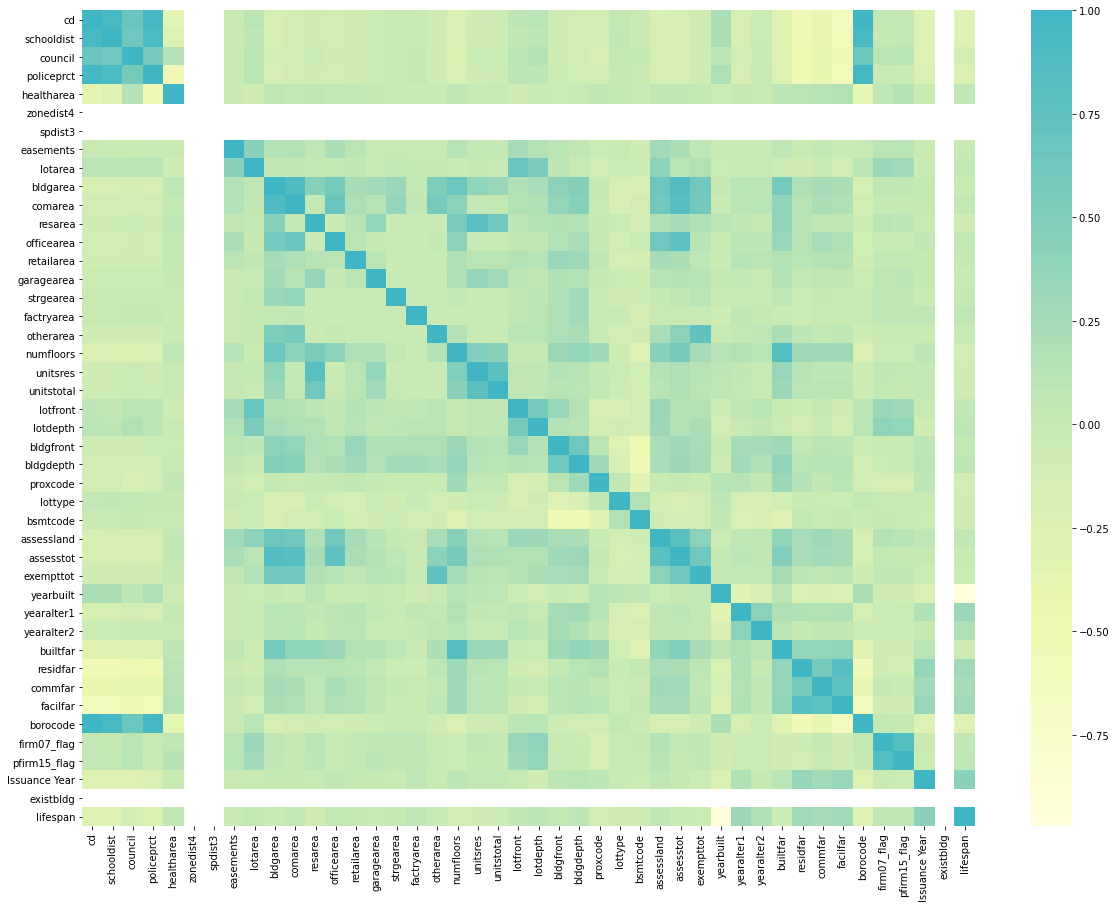

In [35]:
# correlation heat map
plt.subplots(figsize=(20,15))
sns.heatmap(demolished_buildings.corr(), center=1, cmap='YlGnBu');

__Heat Map Comments__\
The following variables will be removed because of multicolinearity:
- borocode
- cd
- schooldist
- council
- assessland
- exempttot
- unitsres
- comarea
- resarea
- officearea
- residfar
- commfar
- facilfar
- pfirm15_flag
- firm07_flag
- lotfront
- unitstotal
- bldgarea
- builtfar
- numfloors
- yearalter1
- yearalter2
- garagearea
- easements
- bldgdepth
- lotdepth
- retailarea
- otherarea
- bsmtcode
- proxcode

The following variables will be removed because there is no data:
- zonedist4
- spdist3
- overlay2

The following variables will be removed because it is not relevant:
- edesignum 

The following variables will be removed because it is redundant with another column:
- landuse, is redundant with bldgclass (see Data Dictionary.)

The following variables will be removed because it was used only to filter data, and is not needed for prediction:
- existbldg
- Issuance Year
- Issuance date

#### Removing Multicolinear Features

In [36]:
demolished_buildings = demolished_buildings.drop(axis=1, columns=['borocode', 'cd', 'schooldist', 'council', 'assessland', 'exempttot', 
                                    'unitsres', 'comarea', 'resarea', 'officearea', 'residfar', 'commfar', 'facilfar', 
                                    'pfirm15_flag', 'firm07_flag', 'spdist3', 'lotfront', 'unitstotal', 'bldgarea', 'builtfar',
                                    'numfloors', 'yearalter1', 'yearalter2', 'garagearea', 'easements', 'bldgdepth', 
                                    'lotdepth','zonedist4', 'spdist3', 'overlay2', 'existbldg', 'Issuance Year', 
                                    'retailarea', 'otherarea', 'bsmtcode', 'proxcode', 'edesignum', 'Issuance Date', 'landuse'])

#pickle and copy
with open('data/pickles/demolished_buildings.pickle', 'wb') as f:
    pickle.dump(demolished_buildings, f)

demolished_buildings = demolished_buildings.copy()

Feature descriptions come from the PLUTO data dictionary.

- policeprct - The police precinct in which the tax lot is located.

- healtharea - The health area in which the tax lot is located. Health areas were originally created in the 1920s for the purpose of reporting and  statistical analysis of public health data. They were based on census tracts and created to be areas of equal population.


- zonedist1 - The zoning district classification of the tax lot. Under the Zoning Resolution, the map of New York City is generally apportioned into three basic zoning district categories: Residence (R), Commercial (C) and Manufacturing (M), which are further divided into a range of individual zoning districts, denoted by different number and letter combinations. In general, the higher the number immediately following the first letter (R, C or M), the higher the density or intensity of land use permitted.  

- zonedist2 - If the tax lot is divided by zoning boundary lines, ZONING DISTRICT 2 represents the zoning classification occupying the second greatest percentage of the tax lot's area. Only zoning districts that cover at least 10% of a tax lot’s area are included. 

- zonedist3 - If the tax lot is divided by zoning boundary lines, ZONING DISTRICT 3 represents the zoning classification occupying the third greatest percentage of the tax lot's area. Only zoning districts that cover at least 10% of a tax lot’s area are included. 

- overlay1 - The commercial overlay assigned to the tax lot. A commercial overlay is a C1 or C2 zoning district mapped within residential zoning districts to serve local retail needs (grocery stores, dry cleaners, restaurants, for example). 

- spdist1 - The special purpose district assigned to the tax lot. The regulations for special purpose districts are designed to supplement and modify the underlying zoning in order to respond to distinctive neighborhoods with particular issues and goals. Only special purpose districts that cover at least 10% of a tax lot’s area are included. 

- spdist2 - The special purpose district assigned to the tax lot. The regulations for special purpose districts are designed to supplement and modify the underlying zoning in order to respond to distinctive neighborhoods with particular issues and goals. Only special purpose districts that cover at least 10% of a tax lot’s area are included.  

- ltdheight - The limited height district assigned to the tax lot. A limited height district is superimposed on an area designated as an historic district by the Landmarks Preservation Commission. 

- splitzone - A code indicating whether the tax lot is split between multiple zoning features. The split boundary indicator is equal to “Y” if the tax lot has a value for ZONING DISTRICT 2, COMMERCIAL OVERLAY 2, or SPECIAL DISTRICT BOUNDARY 2.  

- bldgclass - A code describing the major use of structures on the tax lot. BUILDING CLASS is taken from Property Tax System (PTS) without modification. 

&emsp; 01 One & Two Family Buildings \
&emsp; 02 Multi-Family Walk-Up Buildings \
&emsp; 03 Multi-Family Elevator Buildings \
&emsp; 04 Mixed Residential & Commercial Buildings\
&emsp; 05 Commercial & Office Buildings\
&emsp; 06 Industrial & Manufacturing\
&emsp; 07 Transportation & Utility \
&emsp; 08 Public Facilities & Institutions \
&emsp; 09 Open Space & Outdoor Recreation \
&emsp; 10 Parking Facilities \
&emsp; 11 Vacant Land 

- ownertype - A code indicating type of ownership for the tax lot. 

&emsp; C City ownership \
&emsp; M Mixed city & private ownership \
&emsp; O Other – owned by either a public authority or the state or federal government \
&emsp; P Private ownership \
&emsp; X Fully tax-exempt property that may be owned by the city, state, or federal government; a public authority; or a private institution Unknown (usually private ownership) \

- lotarea - Total area of the tax lot, expressed in square feet rounded to the nearest integer. 

- strgearea - An estimate of the exterior dimensions of the portion of the structure(s) allocated for storage or loft purposes.   

- factryarea - An estimate of the exterior dimensions of the portion of the structure(s) allocated for factory, warehouse or loft use. 

- bldgfront - The building’s frontage along the street measured in feet.

- ext - A code identifying whether there is an extension on the lot or a garage other than the primary structure.  

&emsp; E Extension \
&emsp; G Garage \
&emsp; EG Extension and garage \
&emsp; N None

- irrlotcode - A code indicating whether the tax lot is irregularly shaped. 

&emsp; Y Yes, an irregularly shaped lot \
&emsp; N No, not an irregularly shaped lot

- lottype - A code indicating the location of the tax lot in relationship to another tax lot and/or the water. 

- assesstot - The assessed total value for the tax lot. 

- yearbuilt - The date of original construction.

- histdist - The name of the Historic District that the tax lot is within. Historic Districts are designated by the New York City Landmarks Preservation Commission.  

- landmark - This value indicates whether the lot contains an individual landmark building, an interior landmark building, or both.  

- lifespan - the total time the building was in service from date of construction to date of demolition, in years.

__Comments__
- There are too many columns to one-hot encode without creating an extremely large dataframe, so use a feature selection methods will be explored. 
- Selecting the subset of 24 features that seem likely to have a relationship to the 
predictor variable, using business understanding.
- The first batch of models will be done using only the continuous variables. 
- The second batch of models will be done using a larger set of variables.

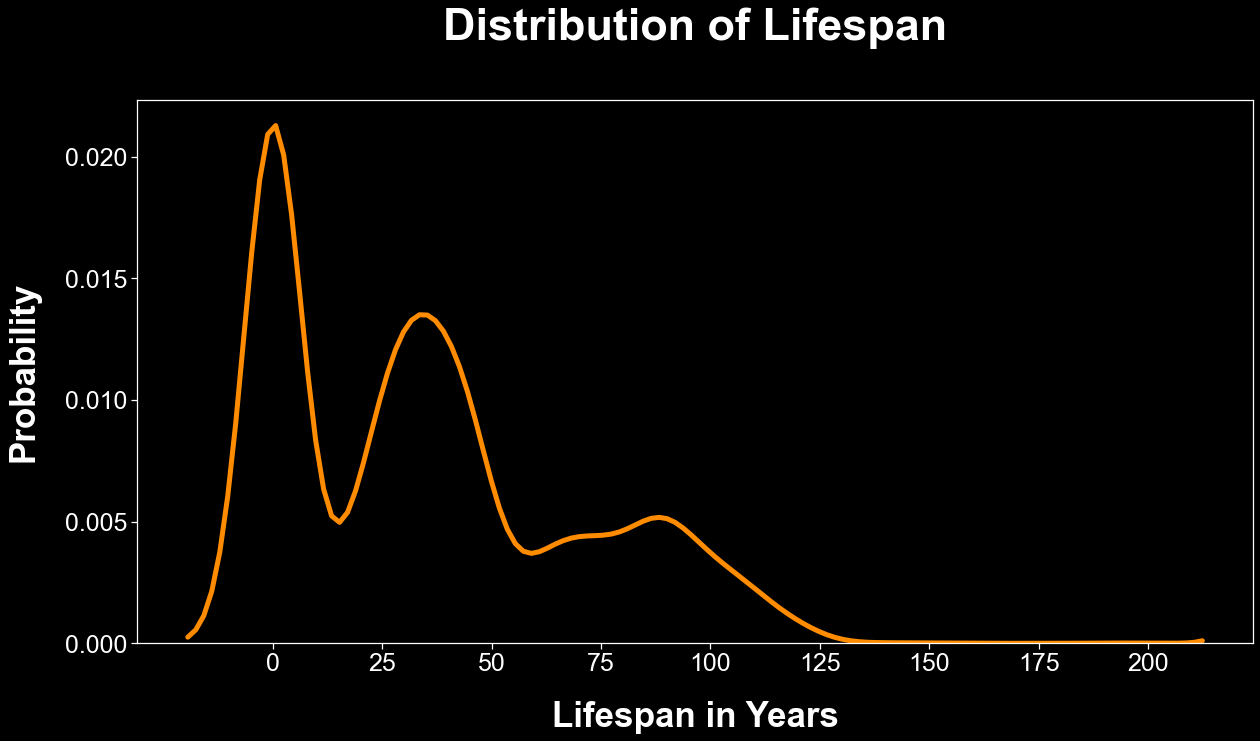

In [39]:
sns.set(rc={'figure.figsize':(20,10)}, style='ticks')
plt.style.use('dark_background')

sns.distplot(demolished_buildings.lifespan, hist=False, kde=True, kde_kws={'linewidth':5}, color='darkorange')

font_lg = {'family': 'sans-serif',
        'color':  'white',
        'weight': 'bold',
        'size': 45,
        }

font_med = {'family': 'sans-serif',
        'color':  'white',
        'weight': 'bold',
        'size': 35,
        }

plt.title('Distribution of Lifespan', fontdict=font_lg, y=1.1)
plt.xlabel('Lifespan in Years', fontdict=font_med, labelpad=25)
plt.ylabel('Probability', fontdict=font_med, labelpad=25)
plt.xticks(ticks=[0, 25, 50, 75, 100, 125, 150, 175, 200], fontsize=25)
plt.yticks(ticks=[0.0, 0.005, 0.01, 0.015, 0.02], fontsize=25);

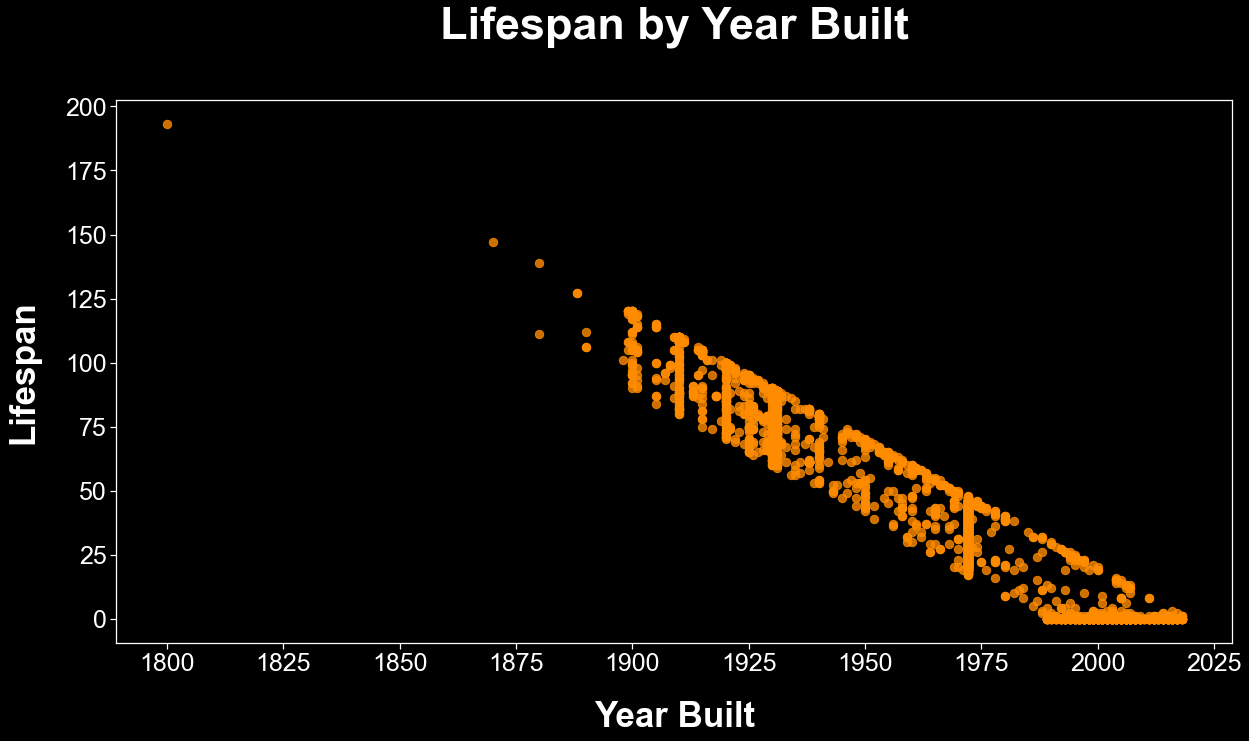

In [40]:
sns.regplot(x=demolished_buildings['yearbuilt'], 
                y=demolished_buildings['lifespan'], fit_reg=False, color='darkorange', scatter_kws={'s':70}
           ).set_title('Lifespan by Year Built');

font_lg = {'family': 'sans-serif',
        'color':  'white',
        'weight': 'bold',
        'size': 45,
        }

font_med = {'family': 'sans-serif',
        'color':  'white',
        'weight': 'bold',
        'size': 35,
        }

plt.title('Lifespan by Year Built', fontdict=font_lg, y=1.1)
plt.xlabel('Year Built', fontdict=font_med, labelpad=25)
plt.ylabel('Lifespan', fontdict=font_med, labelpad=25)
plt.xticks(ticks=[1800, 1825, 1850, 1875, 1900, 1925, 1950, 1975, 2000, 2025], fontsize=25)
plt.yticks(ticks=[0, 25, 50, 75, 100, 125, 150, 175, 200], fontsize=25);

## Lifespan by Type of Building

Text(0.5, 0, 'Number of Buildings Demolished')

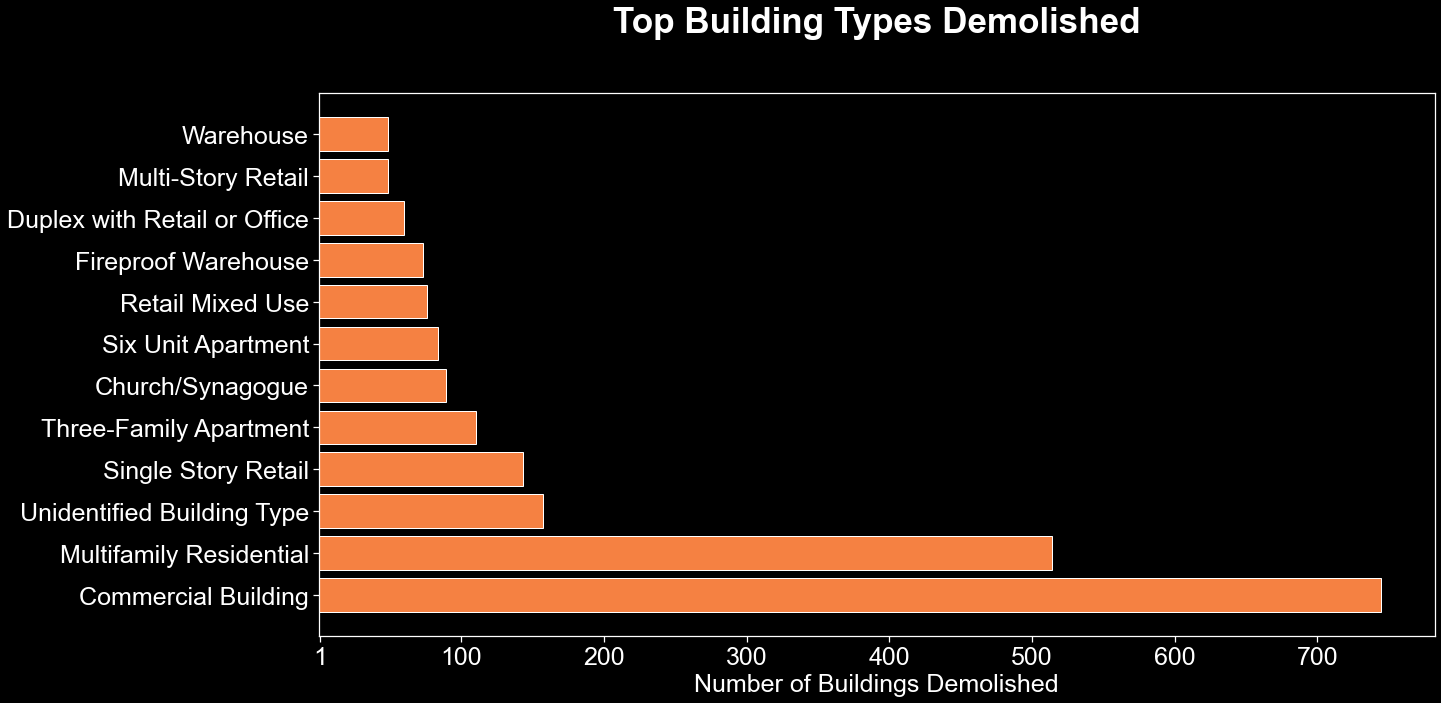

In [41]:
Bldg_class_dict = {'Commercial Building': 745, 'Multifamily Residential': 514, 'Unidentified Building Type':157, 
                   'Single Story Retail':143, 'Three-Family Apartment': 110, 'Church/Synagogue':89, 
                   'Six Unit Apartment': 84, 'Retail Mixed Use': 76, 'Fireproof Warehouse':73, 
                   'Duplex with Retail or Office': 60, 'Multi-Story Retail': 49,
                  'Warehouse':49}

bldg_counts = list(Bldg_class_dict.values())

building_types = list(Bldg_class_dict.keys())

y_pos = np.arange(len(building_types))


font_med = {'family' : 'sans-serif',
        'weight' : 'regular',
        'size'   : 25}

font_lg = {'family' : 'sans-serif',
        'weight' : 'bold',
        'size'   : 35}

plt.barh(y_pos, bldg_counts, height=0.8, align='center', color='#f58142')
plt.title('Top Building Types Demolished', fontdict=font_lg, y=1.1);
plt.yticks(y_pos, building_types, fontsize=25)
plt.xticks(ticks=[1, 100, 200, 300, 400, 500, 600, 700], fontsize=25)
plt.xlabel('Number of Buildings Demolished', fontdict=font_med)

# Modeling

## Import Pickle File

In [43]:
infile = open('data/pickles/demolished_buildings.pickle', 'rb')
demolished_buildings = pickle.load(infile)
infile.close()

## Continuous & Categorical Variables

In [44]:
all_cols = list(demolished_buildings.columns)
all_cols = sorted(all_cols)
all_cols

['assesstot',
 'bldgclass',
 'bldgfront',
 'ext',
 'factryarea',
 'healtharea',
 'histdist',
 'irrlotcode',
 'landmark',
 'lifespan',
 'lotarea',
 'lottype',
 'ltdheight',
 'overlay1',
 'ownertype',
 'policeprct',
 'spdist1',
 'spdist2',
 'splitzone',
 'strgearea',
 'yearbuilt',
 'zonedist1',
 'zonedist2',
 'zonedist3']

In [45]:
# making a list of continuous columns
cont_cols = ['lotarea', 'strgearea','factryarea', 'bldgfront', 'assesstot', 'yearbuilt']

# making a dataframe of continuous columns
cont_cols_df = demolished_buildings[['lotarea', 'strgearea','factryarea', 'bldgfront', 'assesstot', 'yearbuilt']]

#making a list of categorical columns
cat_cols = []

for col in all_cols:
    if col in cont_cols:
        pass
    if col == 'lifespan':
        pass
    else:
        cat_cols.append(col)
    
print(cat_cols)
print(len(cat_cols))

['assesstot', 'bldgclass', 'bldgfront', 'ext', 'factryarea', 'healtharea', 'histdist', 'irrlotcode', 'landmark', 'lotarea', 'lottype', 'ltdheight', 'overlay1', 'ownertype', 'policeprct', 'spdist1', 'spdist2', 'splitzone', 'strgearea', 'yearbuilt', 'zonedist1', 'zonedist2', 'zonedist3']
23


## Train Test Split

In [46]:
# try a model using only continous variables
X = cont_cols_df
y = demolished_buildings['lifespan']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=12)

## Model 1 : Linear Regression

Using Continuous Variables only.

### From Scratch

In [47]:
model1 = LinearRegression(fit_intercept=True, copy_X=True).fit(X_train, y_train)

#make predictions using test set
y_pred1 = model1.predict(X_test)

# find coefficients
model_1_coef = model1.coef_
print('Coefficients: ', model_1_coef)

# find mean squared error
MSE = mean_squared_error(y_test, y_pred1)
print('Mean Squared Error ', MSE)

#find root mean squared error RMSE
print('Root Mean Squared Error ', np.sqrt(MSE))

#MAE = mean_absolute_error(y, y_pred1)
# find mean absolute error
#print('Mean Absolute Error ', MAE)

print('R-Squared', r2_score(y_test, y_pred1))

print('Accuracy Score ', model1.score(X_test, y_test))

Coefficients:  [-3.16518619e-06 -1.40434778e-05  4.64912955e-05  1.90016727e-02
  1.76669125e-10 -1.03931183e+00]
Mean Squared Error  83.50043288795412
Root Mean Squared Error  9.137857127792824
R-Squared 0.9016724101573149
Accuracy Score  0.9016724101573149


In [48]:
coefficients1 = dict(zip(cont_cols, model_1_coef))
coefficients1

{'lotarea': -3.165186189328124e-06,
 'strgearea': -1.4043477822092771e-05,
 'factryarea': 4.649129550462128e-05,
 'bldgfront': 0.01900167271613683,
 'assesstot': 1.7666912452889011e-10,
 'yearbuilt': -1.039311825265042}

In [49]:
cross_val_score(estimator = model1, X=X_test, y=y_test, cv=None)

array([0.89272863, 0.88147014, 0.90693815, 0.90168005, 0.90782767])

In [50]:
y_pred1

array([ 84.12363141, 101.33359138,  35.37609118, ...,  34.97352758,
        78.52649538,  34.97651041])

__Comments__

Even though most of the data did not have a linear relationship to the target variable, the model performed well. 

The r-squared value is 0.90, which means that the model explains 90% of the variation in building lifespan.

The coefficients indicate tha factryarea and assesstot have the strongest influence on lifespan.

An RMSE of 9.1 means that the predictions are off by 9 years on average in either direction.

### Using Statsmodels

In [51]:
Xcont_train = sm.add_constant(X_train)
Xcont_test = sm.add_constant(X_test)

model = sm.OLS(y_train, Xcont_train)
fitted_model = model.fit()
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               lifespan   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.903
Method:                 Least Squares   F-statistic:                     3675.
Date:                Thu, 03 Sep 2020   Prob (F-statistic):               0.00
Time:                        09:00:41   Log-Likelihood:                -8551.1
No. Observations:                2373   AIC:                         1.712e+04
Df Residuals:                    2366   BIC:                         1.716e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2084.5033     14.479    143.967      0.000    2056.110    2112.896
lotarea    -3.165e-06   1.19e-06     -2.650      0.008   -5.51e-06   -8.23e-07
strgearea  -1.404e-05    5.6e-06     -2.508      0.012    -2.5e-05   -3.06e-06
factryarea  4.649e-05   4.17e-05      1.115      0.265   -3.53e-05       0.000
bldgfront      0.0190      0.004      4.854      0.000       0.011       0.027
assesstot   1.767e-10   1.91e-08      0.009      0.993   -3.73e-08    3.76e-08
yearbuilt     -1.0393      0.007   -140.685      0.000      -1.054      -1.025
==============================================================================
Omnibus:                      982.092   Durbin-Watson:                   2.063
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              162.554
Skew:                          -0.329   Prob(JB):                     5.03e-36
Kurtosis:                       1.899   Cond. No.                     8.04e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.04e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [52]:
y_predict = fitted_model.predict(Xcont_test)

__Comments__

R-squared of 0.903 means that the coefficients are explaining 90% of the variation of the target variable, lifespan. 

This model is a double check confirming the results of the first model.

P-value for factryarea and assesstot are > 0.05, so these coefficients are irrelevant for predicting the target and should be dropped. However, this will result in less than 5 variables, so some of the categorical variables will need to be added.


## Model 3: Polynomial Regression

In [53]:
# Polynomial Regression

pf = PolynomialFeatures(degree = 4, interaction_only=False, include_bias=True)
poly_data = pf.fit_transform(X_train)
poly_cols = pf.get_feature_names(input_features = cont_cols)
poly_df = pd.DataFrame(poly_data, columns = poly_cols, index = y_train.index)
poly_df.head(3)

,1,lotarea,strgearea,factryarea,bldgfront,assesstot,yearbuilt,lotarea^2,lotarea strgearea,lotarea factryarea,...,bldgfront^2 yearbuilt^2,bldgfront assesstot^3,bldgfront assesstot^2 yearbuilt,bldgfront assesstot yearbuilt^2,bldgfront yearbuilt^3,assesstot^4,assesstot^3 yearbuilt,assesstot^2 yearbuilt^2,assesstot yearbuilt^3,yearbuilt^4
28913,1.0,1875.0,0.0,0.0,20.0,46860.0,1920.0,3515625.0,0.0,0.0,...,1.474560e+09,2.057960e+15,8.432101e+13,3.454894e+12,1.415578e+11,4.821799e+18,1.975641e+17,8.094817e+15,3.316698e+14,1.358954e+13
12976,1.0,4121.0,0.0,0.0,36.0,250200.0,1961.0,16982641.0,0.0,0.0,...,4.983795e+09,5.638511e+17,4.419312e+15,3.463738e+13,2.714784e+11,3.918765e+21,3.071422e+19,2.407298e+17,1.886775e+15,1.478803e+13
13333,1.0,26615.0,0.0,0.0,0.0,138480.0,1972.0,708358225.0,0.0,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.677462e+20,5.236825e+18,7.457408e+16,1.061959e+15,1.512264e+13


In [54]:
poly_model = sm.OLS(y_train, poly_data, hasconst = True)
poly_model_fitted = poly_model.fit()
poly_model_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               lifespan   R-squared:                      -2.906
Model:                            OLS   Adj. R-squared:                 -2.943
Method:                 Least Squares   F-statistic:                    -79.47
Date:                Thu, 03 Sep 2020   Prob (F-statistic):               1.00
Time:                        09:01:04   Log-Likelihood:                -12937.
No. Observations:                2373   AIC:                         2.592e+04
Df Residuals:                    2350   BIC:                         2.605e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.652e-19   1.92e-20      8.600      0.000    1.28e-19    2.03e-19
x1         -3.747e-19   4.44e-20     -8.436      0.000   -4.62e-19   -2.88e-19
x2          1.103e-21   3.72e-22      2.968      0.003    3.74e-22    1.83e-21
x3         -1.561e-23   9.99e-24     -1.563      0.118   -3.52e-23    3.97e-24
x4          1.085e-23   2.83e-24      3.828      0.000    5.29e-24    1.64e-23
x5         -1.772e-23    5.1e-24     -3.475      0.001   -2.77e-23   -7.72e-24
x6          1.193e-24   3.39e-25      3.514      0.000    5.27e-25    1.86e-24
x7          1.966e-24   4.52e-25      4.345      0.000    1.08e-24    2.85e-24
x8           9.92e-25   3.05e-25      3.252      0.001    3.94e-25    1.59e-24
x9          1.122e-24   2.97e-25      3.778      0.000     5.4e-25     1.7e-24
x10         2.005e-24   5.75e-25      3.489      0.000    8.78e-25    3.13e-24
x11         5.136e-24    6.6e-25      7.780      0.000    3.84e-24    6.43e-24
x12         6.961e-24   2.01e-24      3.472      0.001    3.03e-24    1.09e-23
x13         1.099e-22   3.15e-23      3.484      0.001     4.8e-23    1.72e-22
x14          4.62e-22   1.34e-22      3.439      0.001    1.99e-22    7.26e-22
x15         4.797e-24   3.43e-24      1.399      0.162   -1.93e-24    1.15e-23
x16        -9.077e-22   2.99e-22     -3.031      0.002    -1.5e-21    -3.2e-22
x17         2.181e-28   5.62e-29      3.879      0.000    1.08e-28    3.28e-28
x18         6.354e-28   1.44e-28      4.412      0.000    3.53e-28    9.18e-28
x19         1.125e-29   2.88e-30      3.909      0.000    5.61e-30    1.69e-29
x20         2.753e-26   6.59e-27      4.178      0.000    1.46e-26    4.05e-26
x21         1.729e-28   4.35e-29      3.971      0.000    8.75e-29    2.58e-28
x22        -8.223e-31   2.93e-31     -2.807      0.005    -1.4e-30   -2.48e-31
x23         2.668e-26   5.91e-27      4.516      0.000    1.51e-26    3.83e-26
x24         3.111e-29   7.95e-30      3.913      0.000    1.55e-29    4.67e-29
x25         4.532e-23   7.67e-24      5.908      0.000    3.03e-23    6.04e-23
x26         7.436e-25   1.75e-25      4.246      0.000       4e-25    1.09e-24
x27         2.557e-27   6.64e-28      3.854      0.000    1.26e-27    3.86e-27
x28         1.254e-21   3.41e-22      3.677      0.000    5.85e-22    1.92e-21
x29         5.659e-23   1.29e-23      4.393      0.000    3.13e-23    8.18e-23
x30         4.552e-24   1.08e-24      4.203      0.000    2.43e-24    6.68e-24
x31         1.808e-23   4.68e-24      3.861      0.000     8.9e-24    2.73e-23
x32        -1.604e-21   8.88e-22     -1.806      0.071   -3.35e-21    1.38e-22
x33         5.679e-22   6.85e-23      8.291      0.000    4.34e-22    7.02e-22
x34         2.067e-23    4.9e-24      4.221      0.000    1.11e-23    3.03e-23
x35        -2.043e-26   4.64e-27     -4.400      0.000   -2.95e-26   -1.13e-26
x3

__Comments__

An R-squared value of -2.9 is very poor. A negative r-squared means that the model is no better than taking the mean value. The model is not capturing any information from the variables.

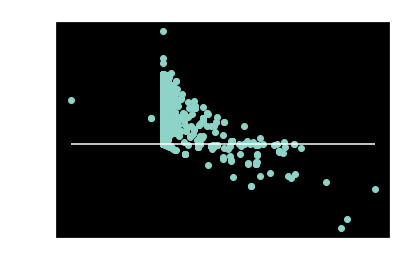

In [56]:
y_poly_predict = poly_model_fitted.predict(poly_data)

poly_residuals = y_train - y_poly_predict
plt.scatter(y_poly_predict, poly_residuals)
plt.hlines(y = 0, xmin = y_poly_predict.min(), xmax=y_poly_predict.max())
plt.title('Residual Plot for Polynomial Regression')
plt.xlabel('Predicted Lifespan')
plt.ylabel('Residuals(Errors)')
plt.show()

__Conclusion__

There is a pattern in the residuals plot. This model is performing very poorly.

There are two predicted values that have negative lifespan. This is very usual. Look at the training data to see if there are any negative lifespan values.

## Check Distribution of the Variables

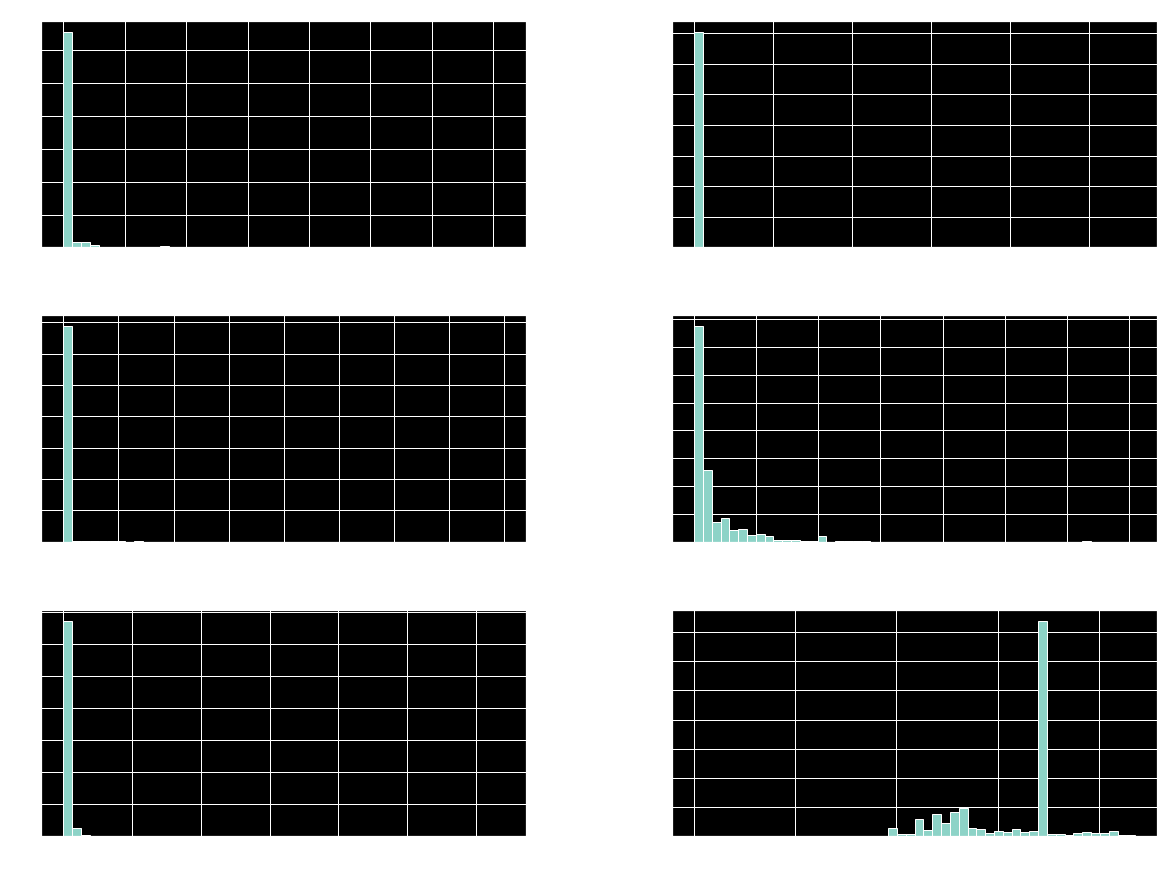

In [57]:
cont_cols_df.hist(bins=50,figsize=(20,15))
plt.show()

__Comments__

The data is highly skewed to the left.

## Normalize

In [58]:
def normalize_data(data, cols):
    """
    Function takes data in the form of a dataframe and returns the normalized data.
    """
    from sklearn.preprocessing import Normalizer

    norm = Normalizer().fit_transform(data)
    new_data = pd.DataFrame(norm, columns=cols)
    return new_data

X_test_norm = normalize_data(X_test, cont_cols)
X_train_norm = normalize_data(X_train, cont_cols)

In [59]:
X_test_norm.head(3)

,lotarea,strgearea,factryarea,bldgfront,assesstot,yearbuilt
0,0.046258,0.0,0.0,0.000278,0.998371,0.033400
1,0.001154,0.0,0.0,0.000016,0.999999,0.000298
2,0.122187,0.0,0.0,0.000102,0.992477,0.007753


In [60]:
def normalize_target(target, name):
    """
    Function takes the target variable as input in the form of a numpy array and returns the normalized array.
    """
    from sklearn.preprocessing import Normalizer
    target = target.to_numpy()
    target = target.reshape(-1, 1)
    norm = Normalizer().fit_transform(target)
    new_target = pd.DataFrame(norm, columns=name)
    return new_target

target_name = ['lifespan']

y_train_norm = normalize_target(y_train, target_name)
y_test_norm = normalize_target(y_test, target_name)

## Scale

In [61]:
def scaler(data):
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)
    scaled_data = pd.DataFrame(scaled_data)
    return scaled_data


X_train_scaled = scaler(X_train_norm)
X_test_scaled = scaler(X_test_norm)
y_train_scaled = scaler(y_train_norm)
y_test_scaled = scaler(y_test_norm)

In [62]:
type(X_train_scaled)

pandas.core.frame.DataFrame

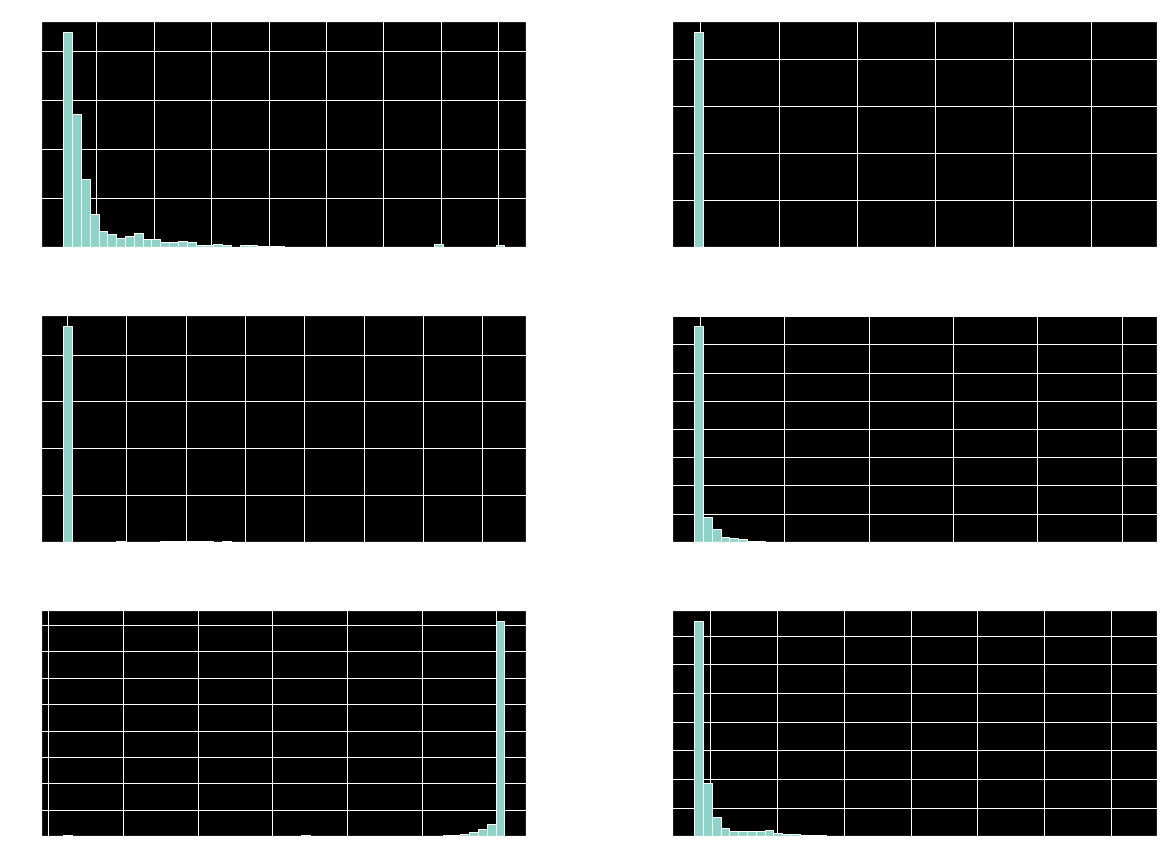

In [63]:
X_train_scaled.hist(bins=50, figsize=(20,15));

__Comments__

Scaling and normalizing had little effect on the distribution. There may be outliers that are affecting the data.

## Model 4: Decision Tree

In [64]:
dt = DecisionTreeRegressor(max_depth=2, criterion='mse', random_state=12, splitter='random', 
                           min_samples_split=2, min_samples_leaf=1)

dt.fit(X_train_scaled, y_train_scaled)

y_pred_dt = dt.predict(X_test_scaled)

dt.score(X_test_scaled, y_pred_dt)

1.0

__Comments__

The decision tree overfit.

The linear regression model performs the best out of the 3 options.